In [49]:
import sys
sys.path.append('../src')

from module.module import Linear
from module.activation import TanH, Softmax, ReLU, Sigmoide

from loss.loss import CrossEntropie, CELogSoftmax
from networks.optim import Optim
from networks.sequentiel import Sequentiel

from utils.generation import generate_linear_data, generate_data_gauss
from utils.plots import plot_net, visualization, net_to_graph

from utils.processing import one_hot_y

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
bodyPerformance_raw = pd.read_csv('../data/bodyPerformance.csv')
print(bodyPerformance_raw.shape)
bodyPerformance_raw.head(2)

(13393, 12)


,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A


In [44]:
bodyPerformance_raw['gender'] = bodyPerformance_raw['gender'].replace({'M': 1, 'F': 0})
bodyPerformance_raw['class'] = bodyPerformance_raw['class'].replace({'A': 1, 'B': 2, 'C': 3, 'D': 4})
bodyPerformance_raw.head(2)

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,1,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,3
1,25.0,1,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,1


In [47]:

# print(bodyPerformance_raw.head(3).to_latex(index=False,float_format="{:.1f}".format, longtable=True ))


In [26]:
y = bodyPerformance_raw['class'].values.reshape(-1,1)
X = bodyPerformance_raw.drop(['class'], axis=1).values

max_X = np.max(X, axis=0)
min_X = np.min(X, axis=0)

X = (X - min_X) / (max_X - min_X)

y.shape, X.shape

((13393, 1), (13393, 11))

100%|██████████| 200/200 [00:26<00:00,  7.52it/s]


Training completed.


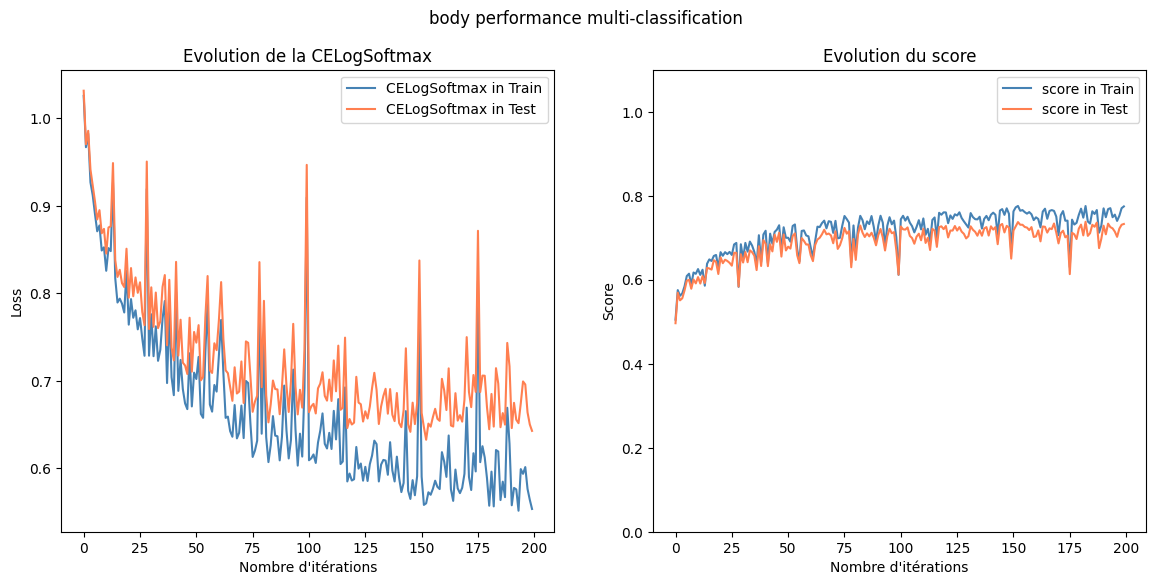

In [18]:
np.random.seed(42)
classes = len(np.unique(y))

input_neurons = X.shape[1]
output_neurons = classes

y_one_hot = one_hot_y(y, classes)

hidden_neurons_1 = 128
hidden_neurons_2 = 64
hidden_neurons_3 = 32

net = Sequentiel([
    Linear(input_neurons, hidden_neurons_1, bias=True),
    ReLU(),
    Linear(hidden_neurons_1, hidden_neurons_2, bias=True),
    ReLU(),
    Linear(hidden_neurons_2, hidden_neurons_3, bias=True),
    ReLU(),
    Linear(hidden_neurons_3, output_neurons, bias=True),
], classes_type="multi")

optim = Optim(net, CELogSoftmax(), eps=1e-3)
optim.SGD(X, y_one_hot, test_train_split=True, batch_size=20, epochs=200, verbose=False)

plot_net(optim, X, y_one_hot, net_type="multiclass", net_title="body performance multi-classification")

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le classificateur SVM
classifier = svm.SVC()

# Entraîner le classificateur
classifier.fit(X_train, y_train.reshape(-1))

# Prédire les étiquettes pour les données de test
y_pred = classifier.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test.reshape(-1), y_pred.reshape(-1))
print("Précision du modèle :", accuracy)

Précision du modèle : 0.6431504292646509


In [50]:
net_to_graph(net = net, horizontal=True)